In [2]:
import pickle

import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from math import isnan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score
from scipy.stats import bootstrap
from scipy.stats import kruskal
from sklearn.metrics import silhouette_samples, adjusted_rand_score, silhouette_score

### Internal functions

In [3]:
def _silhouette_against_chance(y_pred, embeddings):
    # https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/02.5-make-projection-dfs/indv-id/marmoset-make-umap-get-silhouette-vs-chance.ipynb#L4
    emb_coefficients = silhouette_samples(embeddings, labels=y_pred)
    chance_coefficients = silhouette_samples(embeddings, labels=np.random.permutation(y_pred))
    krusk_res = kruskal(emb_coefficients, chance_coefficients)
    return krusk_res

In [4]:
def _silhouette_across_embeddings(y_pred_a, y_pred_b, embeddings):
    # https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/02.5-make-projection-dfs/indv-id/marmoset-make-umap-get-silhouette-vs-chance.ipynb#L4
    a_coefficients = silhouette_samples(embeddings, labels=y_pred_a)
    b_coefficients = silhouette_samples(embeddings, labels=y_pred_b)
    krusk_res = kruskal(a_coefficients, b_coefficients)
    return krusk_res

In [5]:
def _hopkins(X, random_seed):
    """
    Computes Hopkins statistic to avaluate clustering tendency of the dataset.
    
    Parameters:
        X (np.ndarray): The dataset to assess (n_samples, n_features).
        random_seed (int): Seed for random number generation for permutation.
    
    Returns:
        float: The Hopkins statistic (0 to 1). Values closer to 1 indicate clusters, 
               and values closer to 0 indicate uniform distribution.
    
    adapted from https://datascience.stackexchange.com/questions/14142/cluster-tendency-using-hopkins-statistic-implementation-in-python and https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/ accessed November 2024
    """
    # set seeds again to ensure 
    np.random.seed(random_seed)
    random.seed(random_seed)

    d = X.shape[1]
    n = len(X) # rows
    m = int(0.07 * n) # proportion of random subset
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = random.sample(range(0, n, 1), m)
 
    uid = []
    wid = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1), 2, return_distance=True)
        uid.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wid.append(w_dist[0][1])
 
    H = sum(uid) / (sum(uid) + sum(wid))
    if isnan(H):
        print(uid, wid)
        H = 0

    return H

In [6]:
def _v_measure_against_chance(y_true, y_pred, n_permutations=1000, plot=True):
    n_permutations = 1000

    # true V-measure
    res_bootstrap_v = bootstrap((y_true, y_pred), v_measure_score, n_resamples=n_permutations, paired=True)

    true_v_measure = np.mean(res_bootstrap_v.bootstrap_distribution)
    ci_low, ci_high = res_bootstrap_v.confidence_interval.low, res_bootstrap_v.confidence_interval.high
    st_err = res_bootstrap_v.standard_error
    distribution_v = res_bootstrap_v.bootstrap_distribution

    # null distribution of V-measure scores
    null_v_measures = []
    for _ in range(n_permutations):
        permuted_labels = np.random.permutation(y_pred)
        null_v_measures.append(v_measure_score(y_true, permuted_labels))

    # compute chance level as the mean of the null distribution
    chance_level = np.mean(null_v_measures)

    # compute p-value for the true V-measure
    p_value = np.mean([v >= true_v_measure for v in null_v_measures])

    # print(f"V-measure: {true_v_measure}")
    # print(f"Standard error: {st_err}")
    # print(f"Chance level: {chance_level}")
    # print(f"P-value: {p_value:.6f}")

    if plot:
        fig, ax = plt.subplots()
        ax.hist(null_v_measures, bins=20, density=True)
        ax.axvline(true_v_measure, ls="--", color="r")
        score_label = f"V-measure:: {true_v_measure:.3f}±{st_err:.4f}\n(p-value: {p_value:.6f})"
        ax.text(true_v_measure*1.1, 10, score_label, fontsize=12)
        ax.set_xlabel("Accuracy score")
        ax.set_ylabel("Probability density")
        plt.show()

    return true_v_measure, st_err, ci_low, ci_high, p_value, chance_level, distribution_v

In [7]:
def calculate_metrics_clustering(y_true, y_pred, data, representation_type, n_clusters, random_seed=42, plot=True):
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.v_measure_score.html
    
    result = {}
    result['n clusters'] = n_clusters

    if "embedding" in representation_type:
        hopkins = _hopkins(random_seed, data)
        result['Hopkins'] = hopkins
    else: 
        result['Hopkins'] = None
    
    sil_coeffs = silhouette_samples(data, y_pred)
    sil_score = np.mean(sil_coeffs)

    result['Silhouette score/Modularity'] = sil_score
    result['Silhouette coefficients'] = sil_coeffs

    res_bootstrap_h = bootstrap((y_true, y_pred), homogeneity_score, n_resamples=1000, paired=True)
    result['Homogeneity'] = np.mean(res_bootstrap_h.bootstrap_distribution)
    result['Homogeneity CI Low'] = res_bootstrap_h.confidence_interval.low
    result['Homogeneity CI High'] = res_bootstrap_h.confidence_interval.high
    result['Homogeneity Standard Error'] = res_bootstrap_h.standard_error

    res_bootstrap_c = bootstrap((y_true, y_pred), completeness_score, n_resamples=1000, paired=True)
    result['Completeness'] = np.mean(res_bootstrap_c.bootstrap_distribution)
    result['Completeness CI Low'] = res_bootstrap_c.confidence_interval.low
    result['Completeness CI High'] = res_bootstrap_c.confidence_interval.high
    result['Completeness Standard Error'] = res_bootstrap_c.standard_error

    true_v_measure, st_err, ci_low, ci_high, p_value, chance_level, distribution = _v_measure_against_chance(y_true, y_pred, plot=plot)
    result['V-measure'] = true_v_measure
    result['V-measure CI Low'] = ci_low
    result['V-measure CI High'] = ci_high
    result['V-measure Standard Error'] = st_err
    result['V-measure p-value'] = p_value
    result['V-measure Chance Level'] = chance_level
    result['V-measure distribution'] = distribution

    res_bootstrap_rand = bootstrap((y_true, y_pred), adjusted_rand_score, n_resamples=1000, paired=True)
    result['Adjusted Rand Score'] = np.mean(res_bootstrap_rand.bootstrap_distribution)
    result['Adjusted Rand Score CI Low'] = res_bootstrap_rand.confidence_interval.low
    result['Adjusted Rand Score CI High'] = res_bootstrap_rand.confidence_interval.high
    result['Adjusted Rand Score Standard Error'] = res_bootstrap_rand.standard_error
    result['Adjusted Rand Score distribution'] = res_bootstrap_rand.bootstrap_distribution

    return result

### Load data

In [8]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

sns.set_theme("paper")
sns.set_context("talk")

In [9]:
with open("pickles_and_csvs/cluster_labels_embeddings_and_nn_graphs_95.pkl", "rb") as file:
    clusters_dict = pickle.load(file)

Mon Feb 10 14:52:14 2025 Building and compiling search function
Mon Feb 10 14:52:16 2025 Building and compiling search function
Mon Feb 10 14:52:17 2025 Building and compiling search function
Mon Feb 10 14:52:19 2025 Building and compiling search function


In [10]:
representation_keys = ["PAFs", "LFCCs", "Spectrograms", "VAE representations"]
algorithm_keys = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]

##### Hopkins statistic

In [11]:
rows = []
for representation in representation_keys:
    rows.append([representation, _hopkins(clusters_dict[representation]["embeddings"], RANDOM_SEED)])

hopkins_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Hopkins"]
)

hopkins_results

,Representation,Hopkins
0,PAFs,0.930656
1,LFCCs,0.984544
2,Spectrograms,0.879741
3,VAE representations,0.944052


##### Silhouette score and modularity

In [12]:
rows = []
for representation in representation_keys:
    for algorithm in algorithm_keys:
        if algorithm == "Leiden":
            rows.append([representation, algorithm, None, None, None, clusters_dict[representation]["Modularity"]])
            continue
        krusk_res = _silhouette_against_chance(clusters_dict[representation][algorithm], clusters_dict[representation]["embeddings"])
        rows.append([
            representation, 
            algorithm, 
            silhouette_score(clusters_dict[representation]["embeddings"], clusters_dict[representation][algorithm]),
            krusk_res.statistic, 
            krusk_res.pvalue, 
            None])

clusterability_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm", "Silhouette Score", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value", "Modularity"]
)

clusterability_results

,Representation,Algorithm,Silhouette Score,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value,Modularity
0,PAFs,kMeans,0.546160,843.375773,2.003060e-185,NaN
1,PAFs,kMeans-preset,0.545690,849.107431,1.136613e-186,NaN
2,PAFs,HDBSCAN,0.464212,673.476609,1.752059e-148,NaN
3,PAFs,Leiden,NaN,NaN,NaN,0.706141
4,LFCCs,kMeans,0.704687,855.750656,4.086641e-188,NaN
5,LFCCs,kMeans-preset,0.643909,855.456718,4.734441e-188,NaN
6,LFCCs,HDBSCAN,0.704687,855.750656,4.086641e-188,NaN
7,LFCCs,Leiden,NaN,NaN,NaN,0.818335
8,Spectrograms,kMeans,0.650014,855.750656,4.086641e-188,NaN
9,Spectrograms,kMeans-preset,0.439318,820.252610,2.132295e-180,NaN


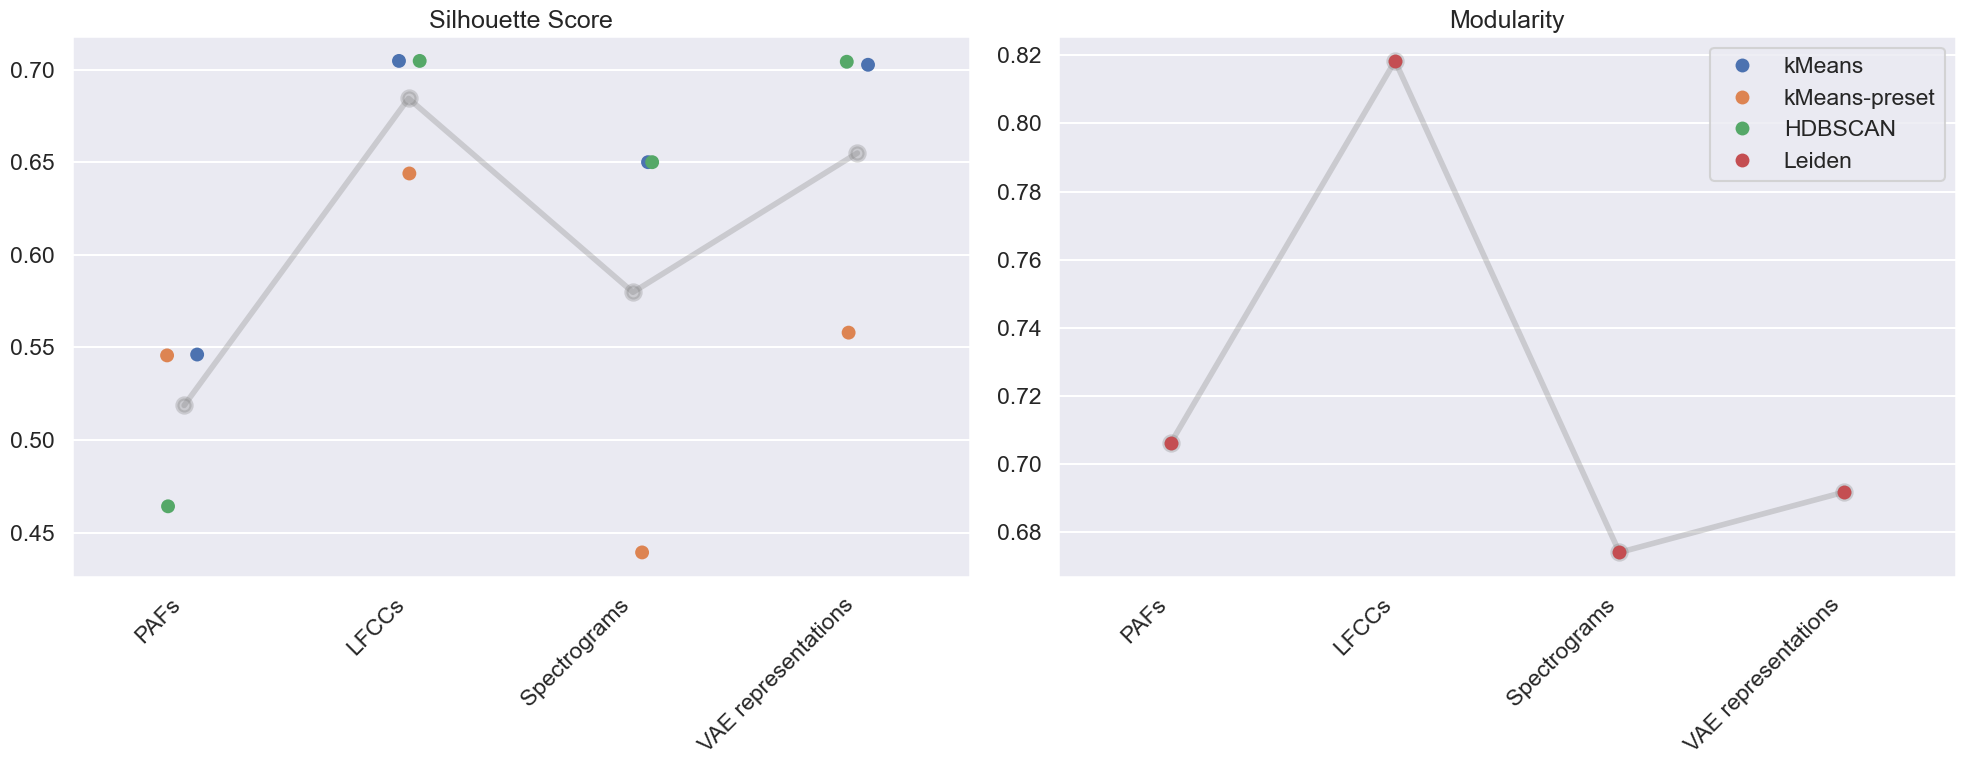

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Silhouette Score", "Modularity"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False)
    )
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=0.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

##### True labels vs predicted labels

In [14]:
rows = []
for representation in representation_keys:
    for algorithm in algorithm_keys:

        _, _, _, _, p_value, chance_level, distribution = _v_measure_against_chance(
            clusters_dict["true_labels"], 
            clusters_dict[representation][algorithm],  
            plot=False)
        
        rows.append([
            representation,
            algorithm,
            p_value,
            chance_level, 
            distribution,
            bootstrap((clusters_dict["true_labels"], clusters_dict[representation][algorithm]), homogeneity_score, n_resamples=1000, paired=True).bootstrap_distribution,
            bootstrap((clusters_dict["true_labels"], clusters_dict[representation][algorithm]), completeness_score, n_resamples=1000, paired=True).bootstrap_distribution,
            bootstrap((clusters_dict["true_labels"], clusters_dict[representation][algorithm]), adjusted_rand_score, n_resamples=1000, paired=True).bootstrap_distribution
        ])

true_vs_pred_df = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm", "p-value", "Chance level", "V measure", "Homogeneity", "Completeness", "Adj. RS"]
)

print(true_vs_pred_df)

         Representation      Algorithm  p-value  Chance level  \
0                  PAFs         kMeans      0.0      0.014617   
1                  PAFs  kMeans-preset      0.0      0.012340   
2                  PAFs        HDBSCAN      0.0      0.010848   
3                  PAFs         Leiden      0.0      0.014478   
4                 LFCCs         kMeans      0.0      0.006371   
5                 LFCCs  kMeans-preset      0.0      0.012458   
6                 LFCCs        HDBSCAN      0.0      0.006309   
7                 LFCCs         Leiden      0.0      0.022064   
8          Spectrograms         kMeans      0.0      0.003508   
9          Spectrograms  kMeans-preset      0.0      0.012737   
10         Spectrograms        HDBSCAN      0.0      0.003608   
11         Spectrograms         Leiden      0.0      0.016369   
12  VAE representations         kMeans      0.0      0.006237   
13  VAE representations  kMeans-preset      0.0      0.012731   
14  VAE representations  

In [15]:
true_vs_pred_df_exploded = true_vs_pred_df.explode(["Homogeneity", "Completeness", "V measure", "Adj. RS"], ignore_index=True)

print(true_vs_pred_df_exploded)

            Representation Algorithm  p-value  Chance level V measure  \
0                     PAFs    kMeans      0.0      0.014617  0.574193   
1                     PAFs    kMeans      0.0      0.014617  0.578328   
2                     PAFs    kMeans      0.0      0.014617  0.585151   
3                     PAFs    kMeans      0.0      0.014617  0.568397   
4                     PAFs    kMeans      0.0      0.014617   0.55288   
...                    ...       ...      ...           ...       ...   
15995  VAE representations    Leiden      0.0      0.012786  0.461347   
15996  VAE representations    Leiden      0.0      0.012786   0.47569   
15997  VAE representations    Leiden      0.0      0.012786  0.478431   
15998  VAE representations    Leiden      0.0      0.012786  0.457412   
15999  VAE representations    Leiden      0.0      0.012786  0.458525   

      Homogeneity Completeness   Adj. RS  
0        0.599434      0.59041  0.522485  
1        0.602666     0.607126  0.505

In [16]:
rows = []
for representation in representation_keys:
    for algorithm in algorithm_keys:

        v_measure, st_err, ci_low, ci_high, p_value, chance_level, _ = _v_measure_against_chance(
            clusters_dict["true_labels"], 
            clusters_dict[representation][algorithm],  
            plot=False)
        
        rows.append([
            representation,
            algorithm,
            v_measure,
            st_err,
            ci_low,
            ci_high,
            p_value,
            chance_level, 
            homogeneity_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm]),
            completeness_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm]),
            adjusted_rand_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm])
        ])

true_vs_pred_df_single_rows = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm", "V measure", "st_err", "ci_low", "ci_high", "p-value", "Chance level", "Homogeneity", "Completeness", "Adj. RS"]
)

print(true_vs_pred_df_single_rows)

         Representation      Algorithm  V measure    st_err    ci_low  \
0                  PAFs         kMeans   0.579594  0.017442  0.528847   
1                  PAFs  kMeans-preset   0.600706  0.018155  0.551357   
2                  PAFs        HDBSCAN   0.629001  0.020119  0.567400   
3                  PAFs         Leiden   0.585782  0.018267  0.526443   
4                 LFCCs         kMeans   0.511982  0.024221  0.453107   
5                 LFCCs  kMeans-preset   0.456362  0.018261  0.407742   
6                 LFCCs        HDBSCAN   0.512832  0.023498  0.450185   
7                 LFCCs         Leiden   0.418916  0.014943  0.373062   
8          Spectrograms         kMeans   0.403421  0.018324  0.358803   
9          Spectrograms  kMeans-preset   0.465056  0.018820  0.409370   
10         Spectrograms        HDBSCAN   0.402949  0.018950  0.351341   
11         Spectrograms         Leiden   0.443491  0.017371  0.396616   
12  VAE representations         kMeans   0.520543  

In [17]:
# # https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/cassins-cluster-label-performance.ipynb
# sns.set_context("paper", font_scale=2)
# fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

# for i, column in enumerate(["Homogeneity", "Completeness", "V measure", "Adj. RI"]):
#     sns.boxplot(x="Representation", y=column, data=true_vs_pred_df, ax=axs[i])
#     sns.swarmplot(x="Representation", y=column, data=true_vs_pred_df, ax=axs[i], color=".25")
#     axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
#     axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
#     axs[i].set_xlabel('')
#     axs[i].set_ylabel('')
#     axs[i].set_title(column)

In [18]:

# # Define columns (metrics)
# columns = ["Homogeneity", "Completeness", "V measure", "Adj. RI"]

# # Get unique values of 'Algorithm' to facet by
# algorithms = true_vs_pred_df['Algorithm'].unique()

# # Create a subplot grid: number of rows equal to the number of columns (metrics)
# # and number of columns equal to the number of unique algorithms
# fig, axs = plt.subplots(nrows=len(columns), ncols=len(algorithms), figsize=(20, 8))

# # Loop through columns (metrics) and algorithms to create each plot
# for i, column in enumerate(columns):
#     for j, algorithm in enumerate(algorithms):
#         # Filter data for the current algorithm
#         algorithm_data = true_vs_pred_df[true_vs_pred_df['Algorithm'] == algorithm]
        
#         # Raw data points
#         sns.stripplot(
#             x="Representation", 
#             y=column, 
#             data=algorithm_data, 
#             ax=axs[i, j], 
#             jitter=True, 
#             size=10, 
#             alpha=0.5, 
#             color='gray'
#         )
        
#         # Mean points
#         sns.pointplot(
#             x="Representation", 
#             y=column, 
#             data=algorithm_data, 
#             ax=axs[i, j], 
#             errorbar=None,
#             markers="o", 
#             color="red"
#         )

#         # Set titles and labels
#         if i == 0:
#             axs[i, j].set_title(algorithm)
#         if j == 0:
#             axs[i, j].set_ylabel(column)
#         else:
#             axs[i, j].set_ylabel('')

#         # Set x-ticks and labels
#         axs[i, j].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
#         axs[i, j].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')

# # Adjust layout
# plt.tight_layout()
# plt.show()


In [19]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# columns = ["Homogeneity", "Completeness", "V measure", "Adj. Rs"]
# representations = ['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations']

# # Create subplots
# fig, axs = plt.subplots(1, len(columns), figsize=(20, 6), sharey=True)

# for i, column in enumerate(columns):
#     ax = axs[i]
    
#     # Raw data points
#     sns.stripplot(
#         x="Representation",
#         y=column,
#         data=true_vs_pred_df,
#         ax=ax,
#         jitter=True,
#         size=8,
#         hue="Algorithm",
#         alpha=0.5,
#         legend=False,  # Avoid duplicate legends
#     )
    
#     # Mean points with error bars
#     sns.pointplot(
#         x="Representation",
#         y=column,
#         data=true_vs_pred_df,
#         ax=ax,
#         errorbar=None,
#         markers="o",
#         color="red",
#     )
    
#     # Customize ticks and labels
#     ax.set_xticks(range(len(representations)))
#     ax.set_xticklabels(representations, rotation=45, ha='right')
#     ax.set_title(column)
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     ax.set_ylim(0.05, 0.8)

# # Adjust layout and add legend only for the last subplot
# handles, labels = axs[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05), title="Algorithm")

# plt.tight_layout()
# plt.show()


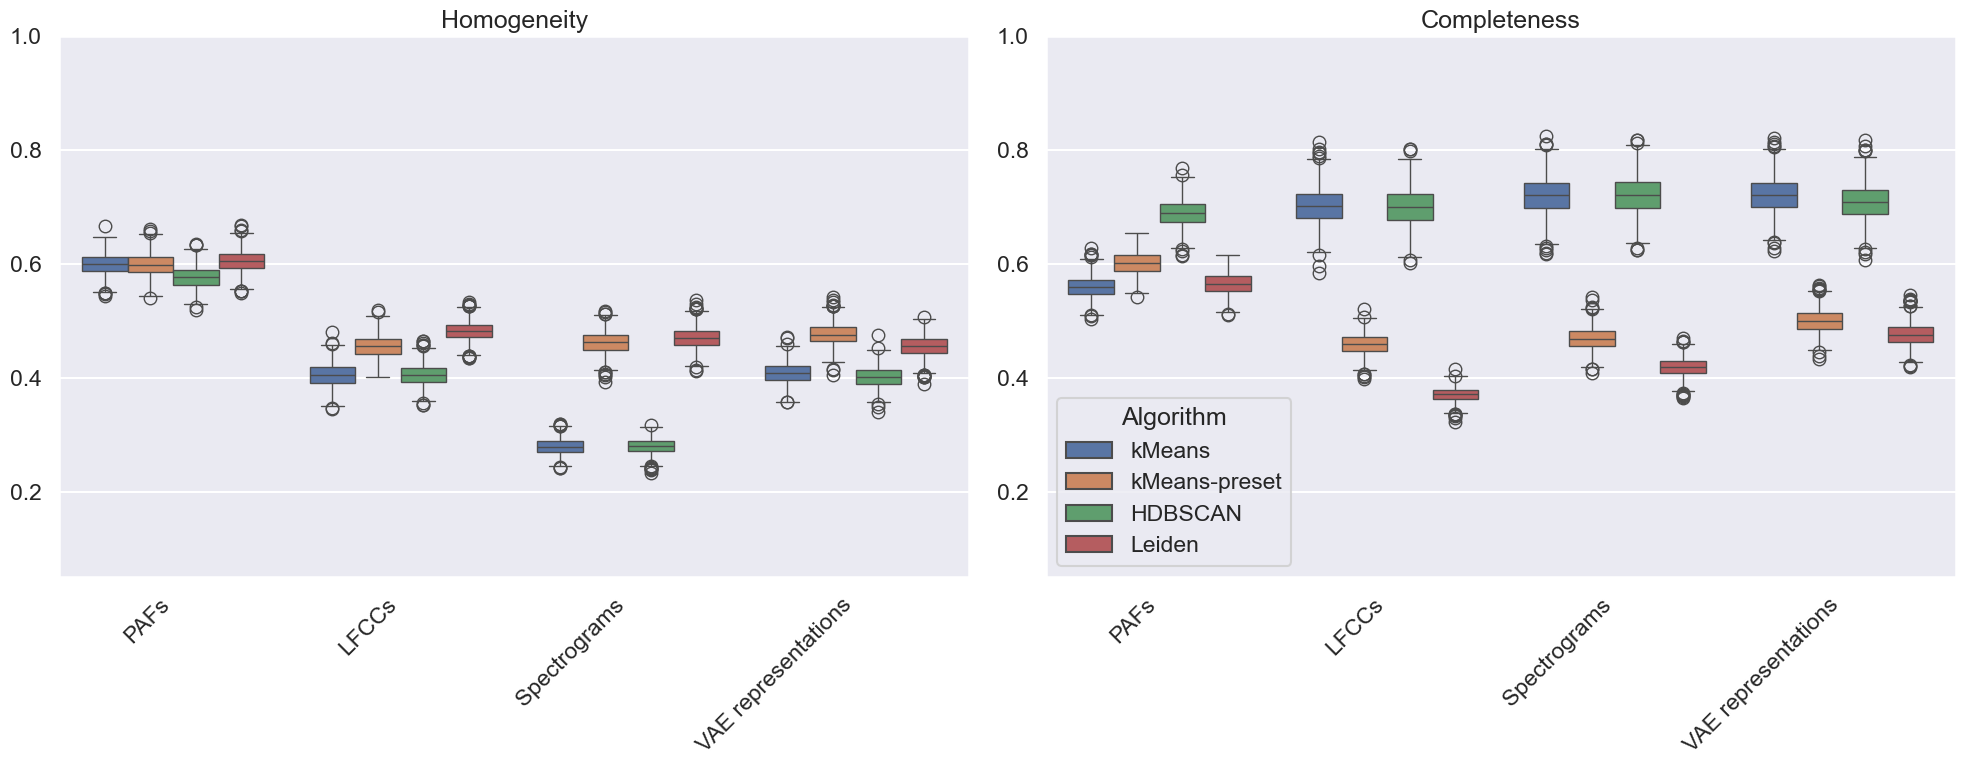

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Homogeneity", "Completeness"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.boxplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False)
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, 1)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

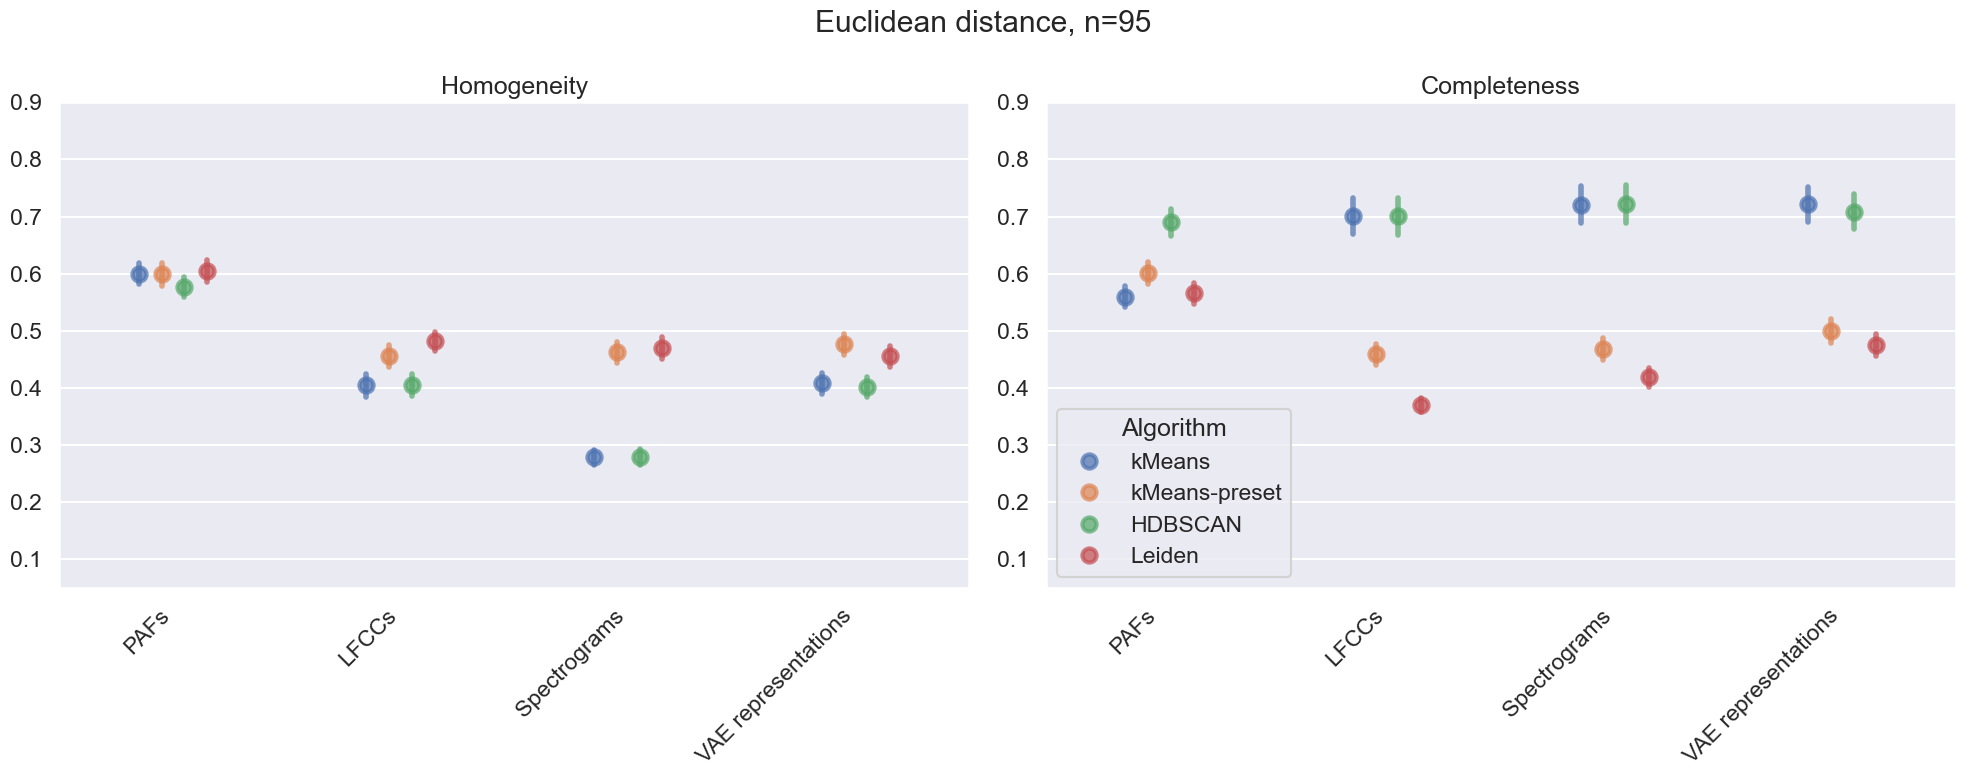

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Homogeneity", "Completeness"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, .9)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

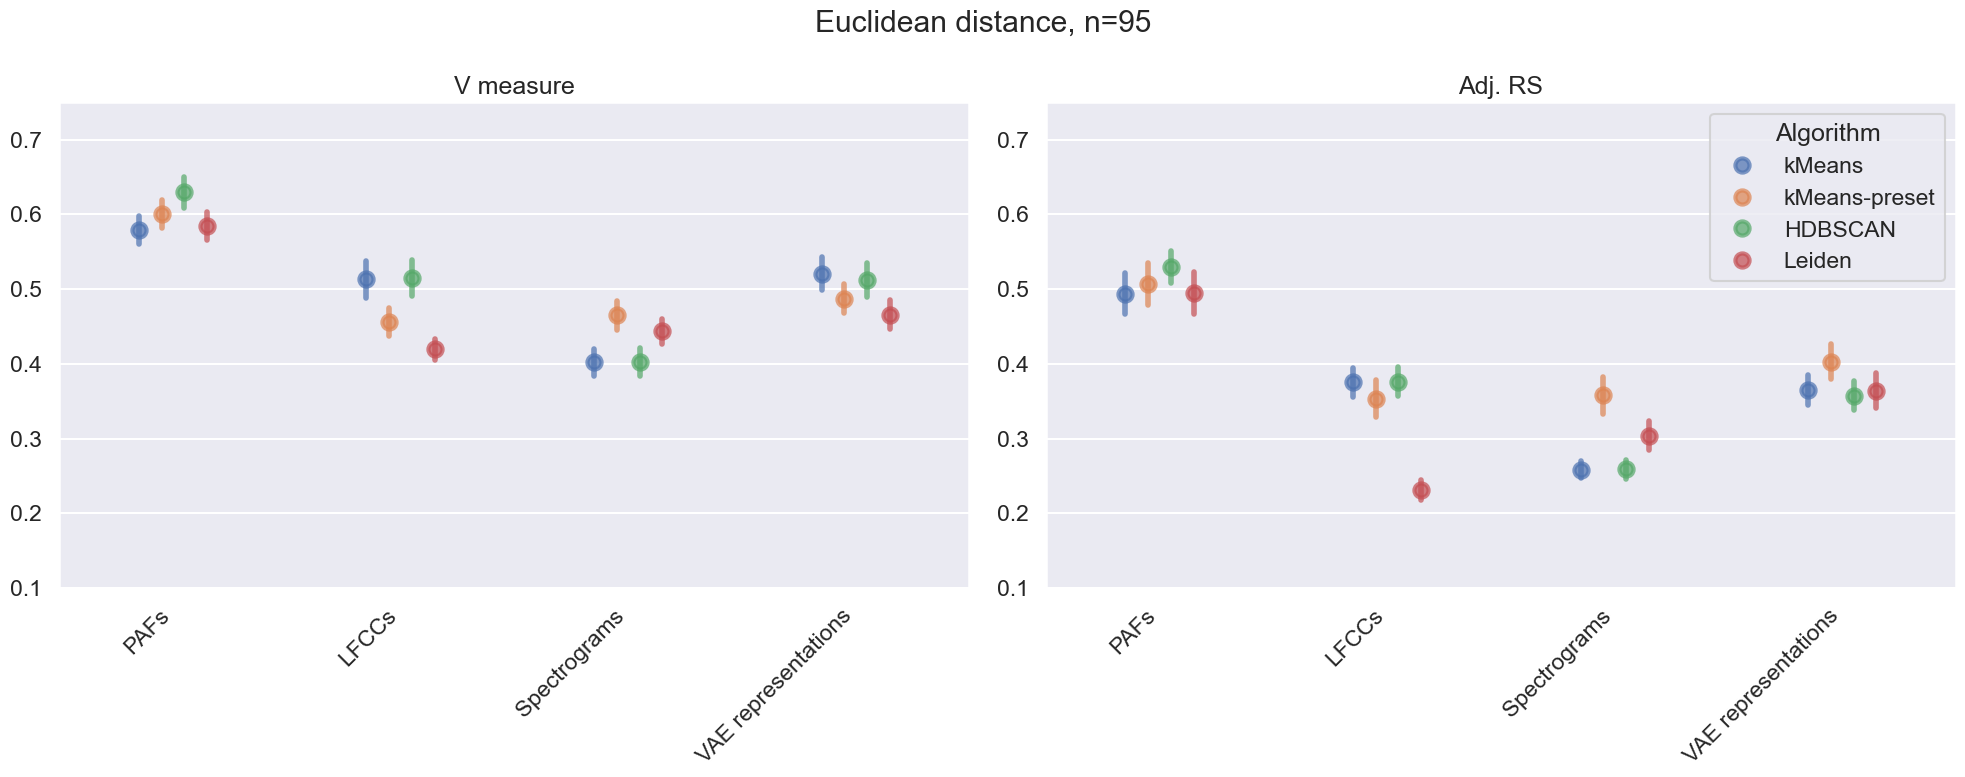

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        linestyle="none",
        alpha=.7,
        errorbar="sd",
        dodge=.3,
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.1, .75)

fig.suptitle("Euclidean distance, n=95")
plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

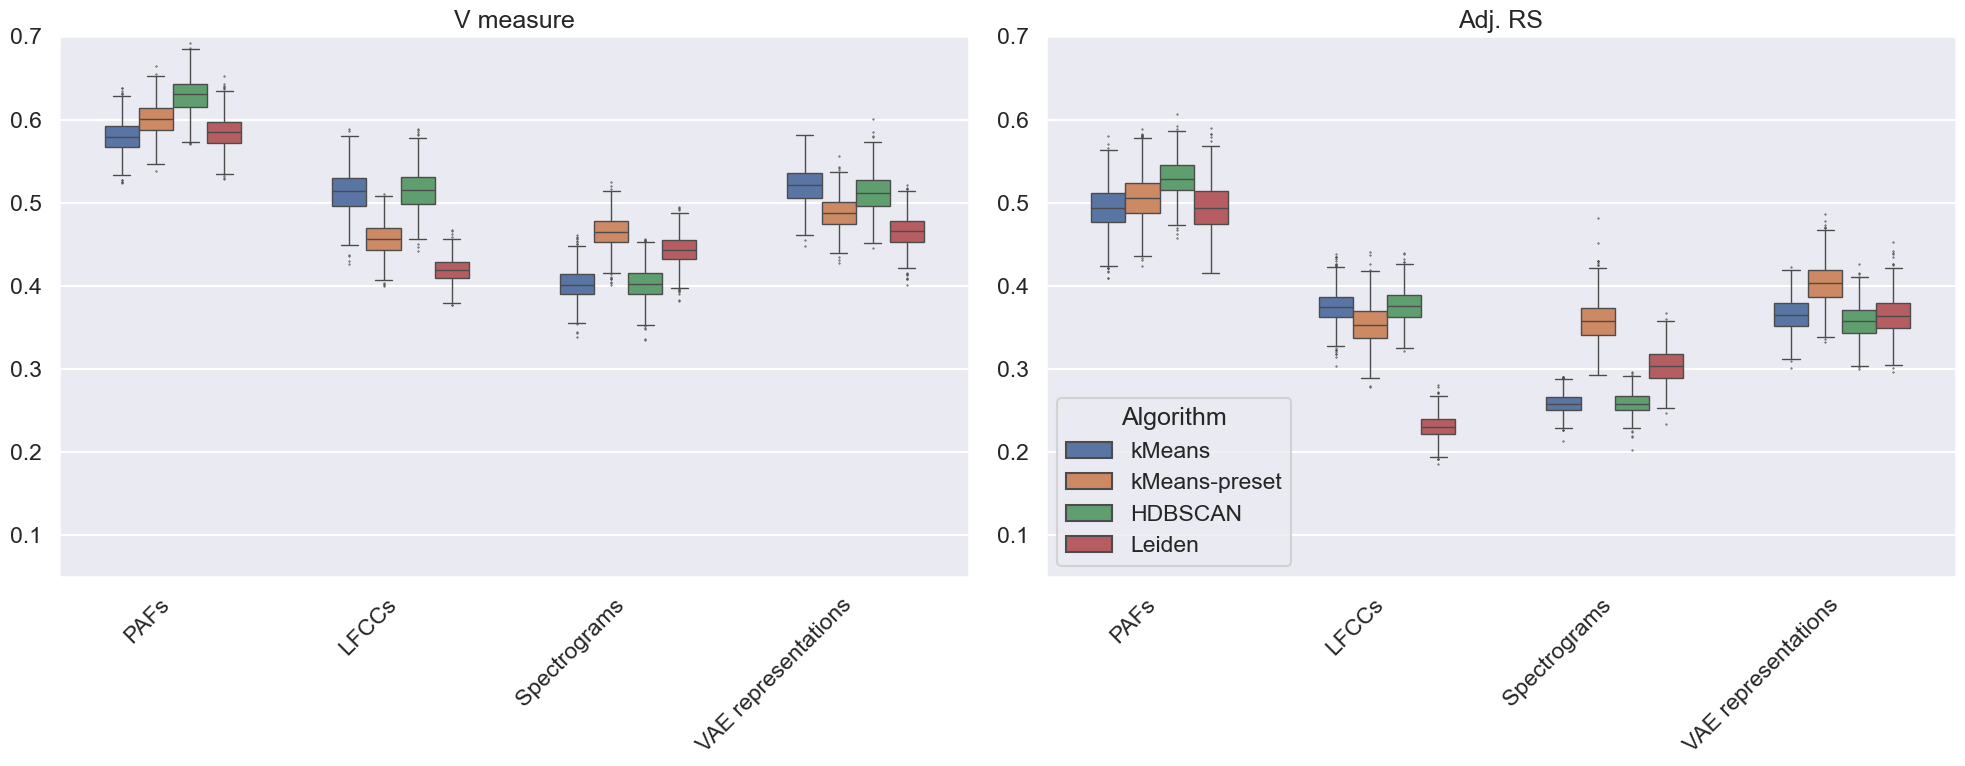

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.boxplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        width=.6,
        fliersize=0.5
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, .7)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

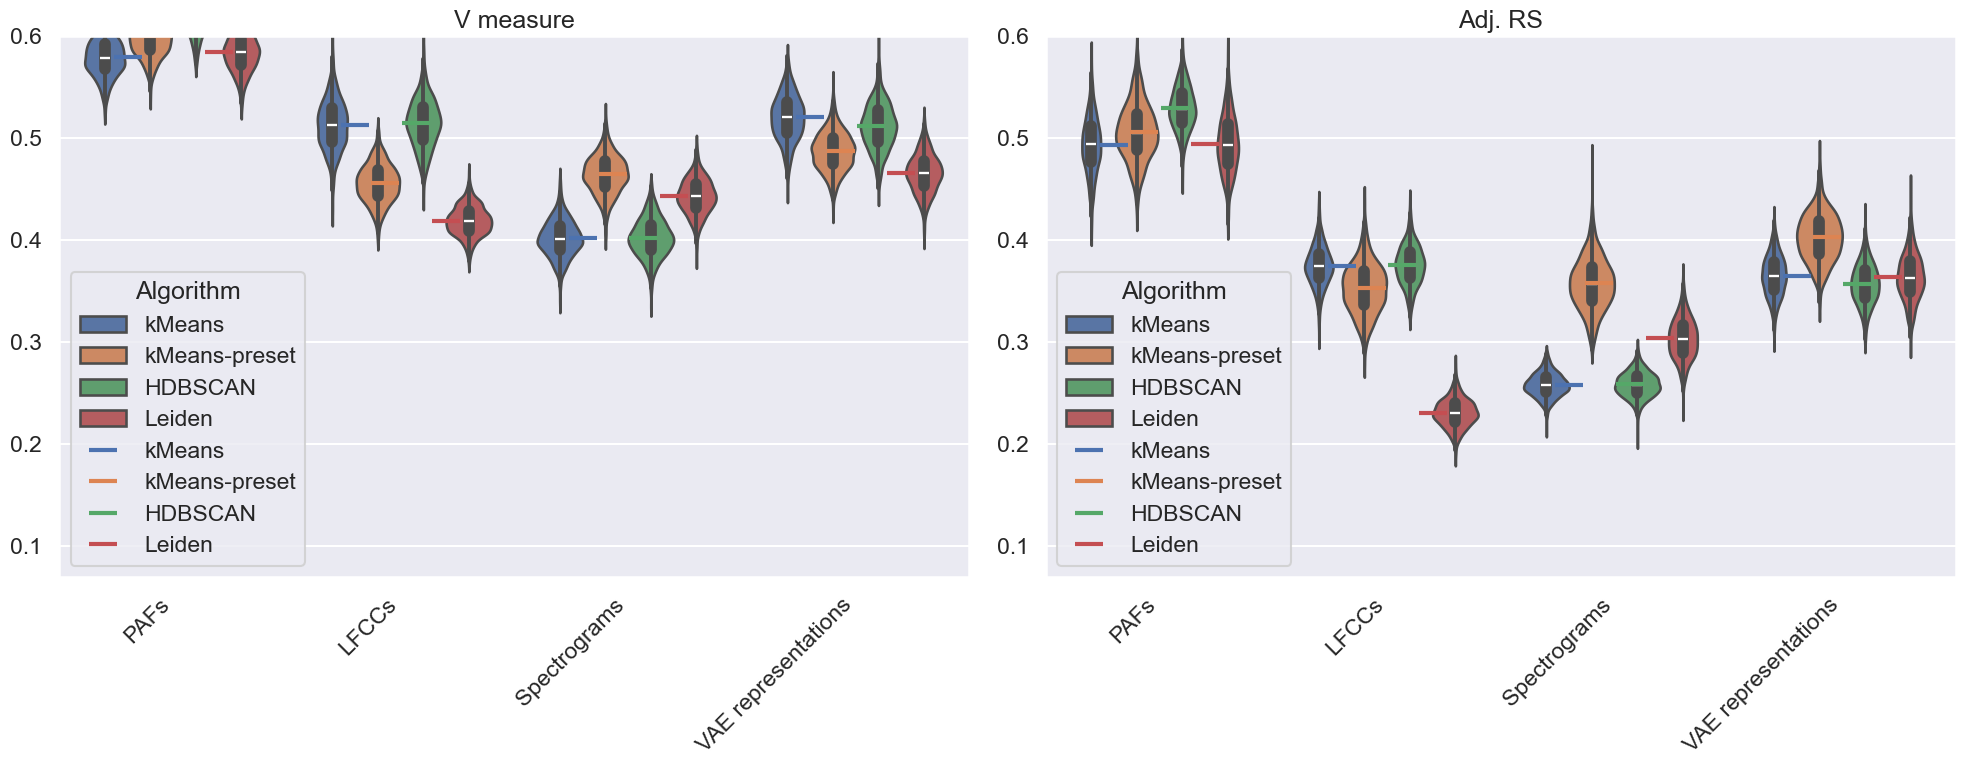

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    sns.violinplot(
        data=true_vs_pred_df_exploded, x="Representation", y=column, hue="Algorithm",
        ax=axs[i], 
    )
    sns.pointplot(
        data=true_vs_pred_df_exploded, x="Representation", y=column, hue="Algorithm",
        dodge=.4, linestyle="none", errorbar=None,
        marker="_", markersize=20, markeredgewidth=3, ax=axs[i], 
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.07, .6)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

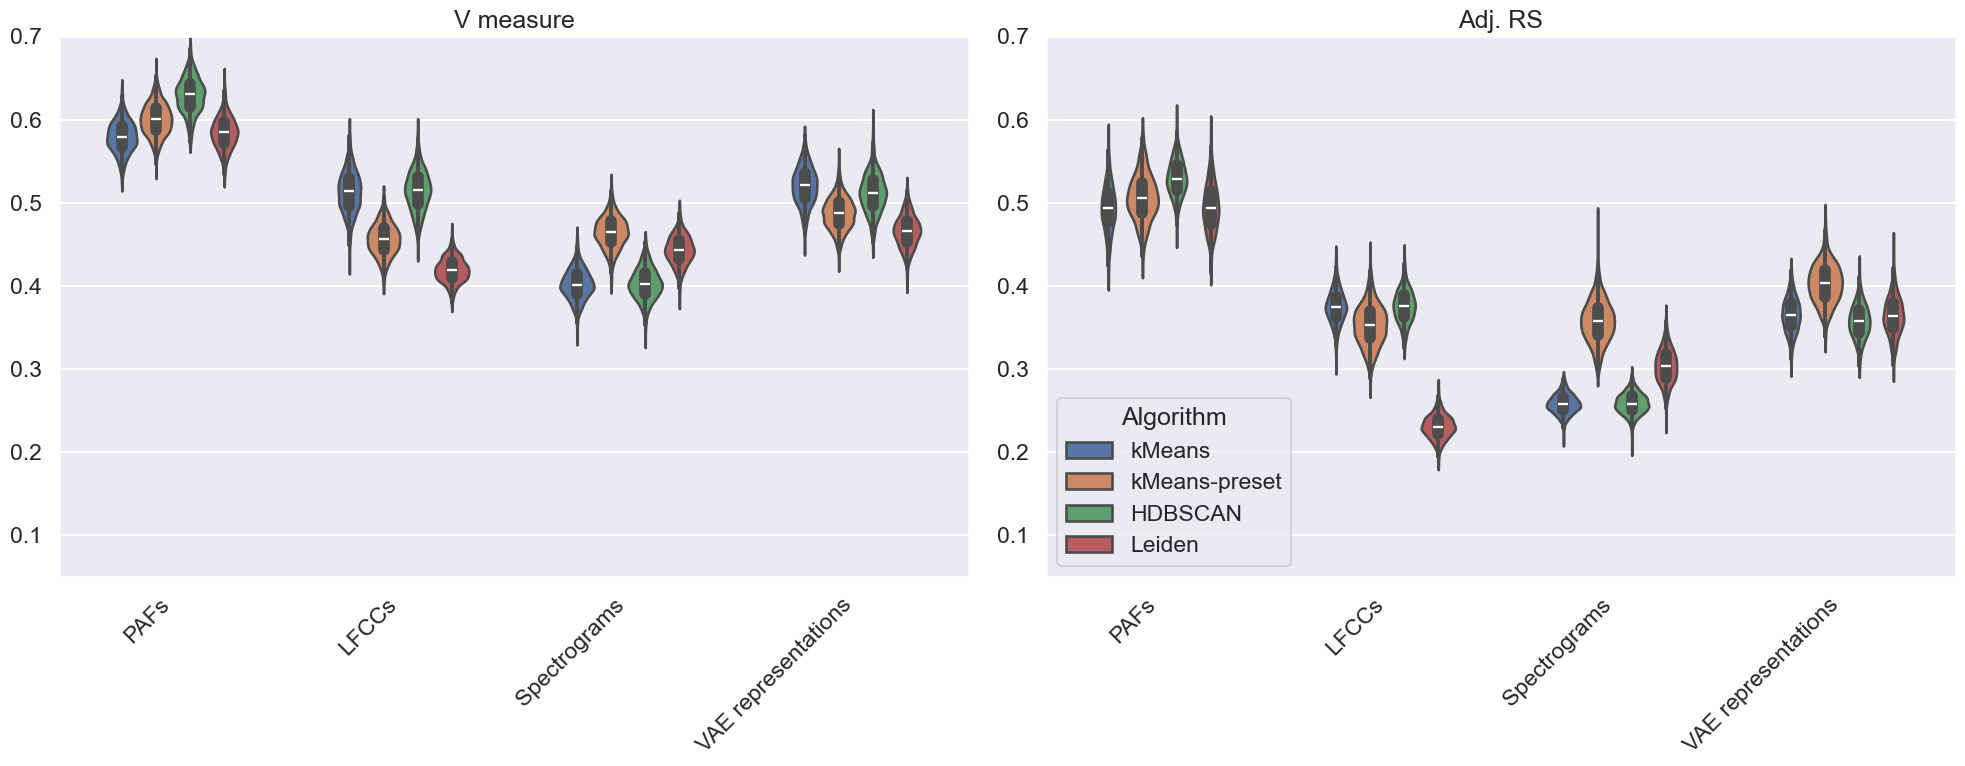

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw datapoints
    sns.violinplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_exploded, 
        ax=axs[i], 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False),
        width=.6
    )
    
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, .7)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

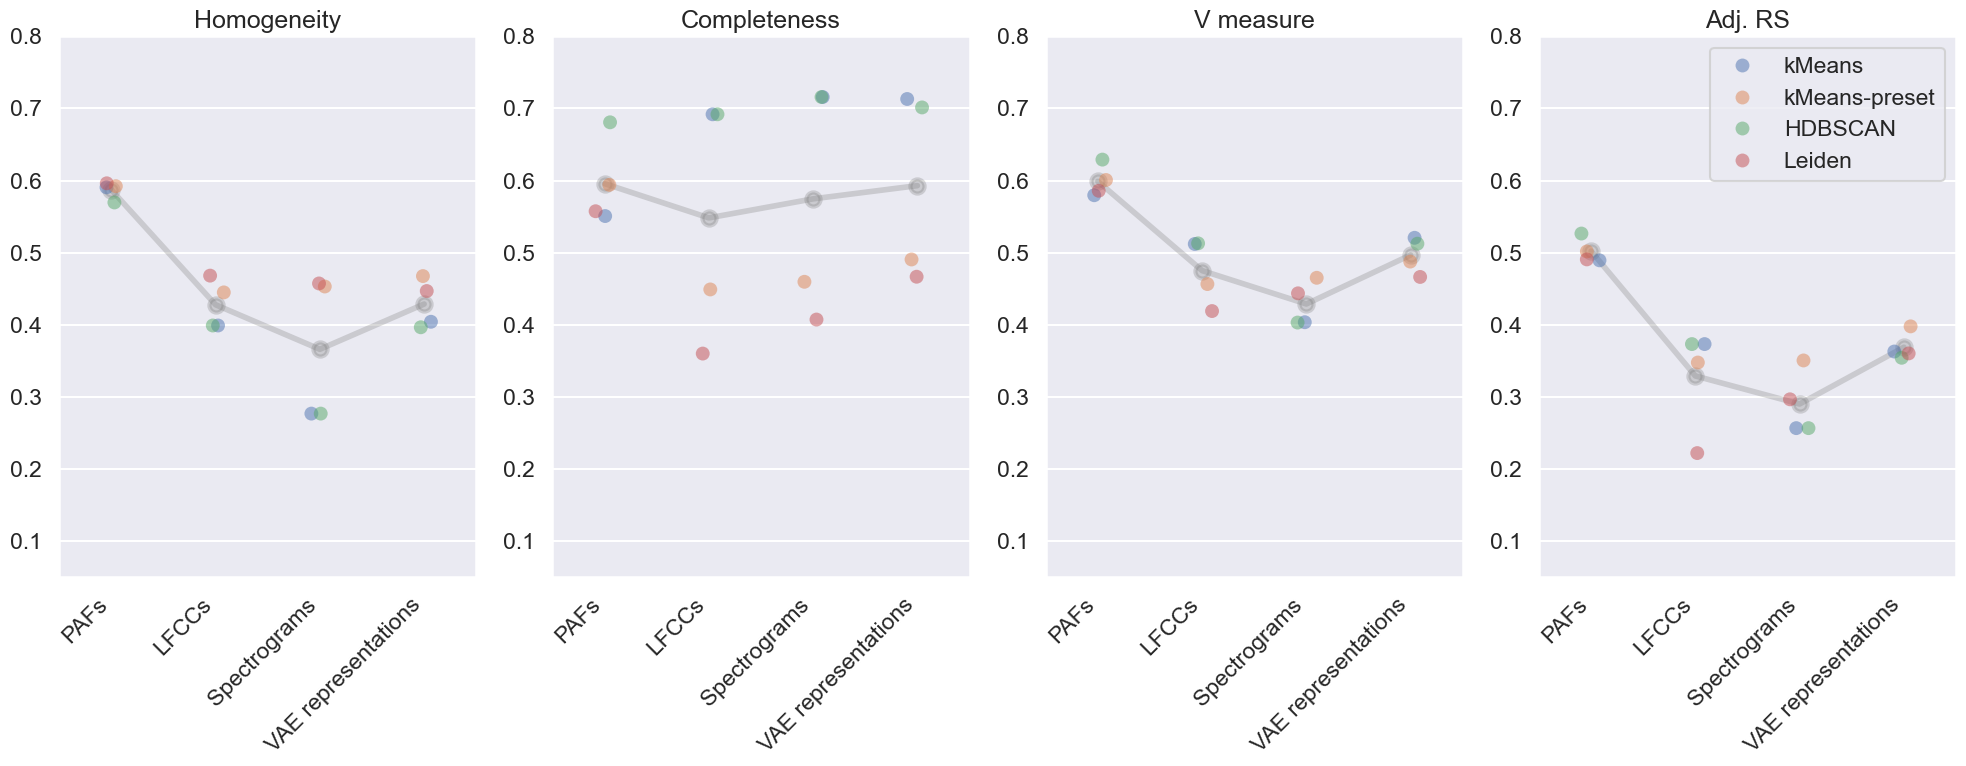

In [26]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["Homogeneity", "Completeness", "V measure", "Adj. RS"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        alpha=0.5, 
        legend=(True if i == len(columns)-1 else False)
    )
    
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df_single_rows, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="grey",
        alpha=.3
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0.05, 0.8)

plt.tight_layout()
plt.show()
# Homogeneity: measures to what proportion clusters contain only data points with the same label
# Completensess: measures if all members of the same class are also members of the same cluster

In [27]:
# # Calculate mean, ci_low, and ci_high for each group
# grouped_data = true_vs_pred_df.groupby(["Representation", "Algorithm"]).agg(
#     mean=(column, "mean"),
#     ci_low=("ci_low", "mean"),
#     ci_high=("ci_high", "mean")
# ).reset_index()

# # Calculate the error margins (absolute differences)
# grouped_data["yerr_lower"] = grouped_data["ci_low"]
# grouped_data["yerr_upper"] = grouped_data["ci_high"]

# for i, column in enumerate(columns):
#     sns.stripplot(
#         x="Representation", 
#         y=column, 
#         data=true_vs_pred_df, 
#         ax=axs[i], 
#         jitter=True, 
#         size=10, 
#         hue="Algorithm", 
#         alpha=0.5, 
#         legend=(True if i == len(columns)-1 else False)
#     )

#     # Plot the error bars manually
#     axs[i].errorbar(
#         x=grouped_data["Representation"],
#         y=grouped_data["mean"],
#         yerr=[grouped_data["yerr_lower"], grouped_data["yerr_upper"]],
#         fmt="o",
#         color="red",
#         capsize=5,
#         label="Mean ± CI"
#     )

#     axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
#     axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
#     axs[i].set_title(column)
#     axs[i].set_xlabel('')
#     axs[i].set_ylabel('')
#     axs[i].set_ylim(0.05, 0.8)

# plt.tight_layout()
# plt.show()

In [28]:
# Generate LaTeX Table
latex_table = true_vs_pred_df.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lllrrllll}
\toprule
 & Representation & Algorithm & p-value & Chance level & V measure & Homogeneity & Completeness & Adj. RS \\
\midrule
0 & PAFs & kMeans & 0.000000 & 0.014617 & [0.57419332 0.57832833 0.58515103 0.56839698 0.55288023 0.53956127
 0.57830503 0.57840253 0.58134272 0.56090938 0.56813373 0.60006569
 0.55889342 0.56525403 0.56593317 0.54618193 0.60854559 0.57683704
 0.60041566 0.59019766 0.56186747 0.5681042  0.57114158 0.56913013
 0.5681001  0.5753158  0.5406049  0.60172039 0.60128239 0.5673498
 0.55677491 0.62380317 0.57356659 0.58405888 0.59713925 0.56320006
 0.60972593 0.54719907 0.58855423 0.54612284 0.60277981 0.61355451
 0.58403284 0.58773198 0.5704692  0.58967226 0.55767763 0.60327638
 0.58552466 0.56769092 0.55684496 0.56695154 0.59861593 0.52339202
 0.59711643 0.59199968 0.58556779 0.60302382 0.59578354 0.54947113
 0.62044845 0.63081409 0.63371305 0.56626

#### Compare algorithms

In [29]:
algorithm_keys_wo_leiden = ["kMeans", "kMeans-preset", "HDBSCAN"]
rows = []
for representation in representation_keys:
    for algorithm_a, algorithm_b in itertools.product(algorithm_keys_wo_leiden, algorithm_keys_wo_leiden):
        if algorithm_a == algorithm_b:
            continue
        krusk_res = _silhouette_across_embeddings(clusters_dict[representation][algorithm_a], clusters_dict[representation][algorithm_b], clusters_dict[representation]["embeddings"])
        rows.append([
            representation, 
            algorithm_a, 
            algorithm_b,
            krusk_res.statistic, 
            krusk_res.pvalue])

silhouette_scores_across_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm a", "Algorithm b", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value"]
)

silhouette_scores_across_results

,Representation,Algorithm a,Algorithm b,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value
0,PAFs,kMeans,kMeans-preset,0.861517,3.533145e-01
1,PAFs,kMeans,HDBSCAN,15.838977,6.896710e-05
2,PAFs,kMeans-preset,kMeans,0.861517,3.533145e-01
3,PAFs,kMeans-preset,HDBSCAN,16.577256,4.670782e-05
4,PAFs,HDBSCAN,kMeans,15.838977,6.896710e-05
5,PAFs,HDBSCAN,kMeans-preset,16.577256,4.670782e-05
6,LFCCs,kMeans,kMeans-preset,19.397055,1.061707e-05
7,LFCCs,kMeans,HDBSCAN,0.000000,1.000000e+00
8,LFCCs,kMeans-preset,kMeans,19.397055,1.061707e-05
9,LFCCs,kMeans-preset,HDBSCAN,19.397055,1.061707e-05


In [30]:
# Generate LaTeX Table
latex_table_2 = silhouette_scores_across_results.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table_2)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{llllrr}
\toprule
 & Representation & Algorithm a & Algorithm b & Silhouette score - Kruskal statistic & Silhouette score - Kruskal p-value \\
\midrule
0 & PAFs & kMeans & kMeans-preset & 0.861517 & 0.353315 \\
1 & PAFs & kMeans & HDBSCAN & 15.838977 & 0.000069 \\
2 & PAFs & kMeans-preset & kMeans & 0.861517 & 0.353315 \\
3 & PAFs & kMeans-preset & HDBSCAN & 16.577256 & 0.000047 \\
4 & PAFs & HDBSCAN & kMeans & 15.838977 & 0.000069 \\
5 & PAFs & HDBSCAN & kMeans-preset & 16.577256 & 0.000047 \\
6 & LFCCs & kMeans & kMeans-preset & 19.397055 & 0.000011 \\
7 & LFCCs & kMeans & HDBSCAN & 0.000000 & 1.000000 \\
8 & LFCCs & kMeans-preset & kMeans & 19.397055 & 0.000011 \\
9 & LFCCs & kMeans-preset & HDBSCAN & 19.397055 & 0.000011 \\
10 & LFCCs & HDBSCAN & kMeans & 0.000000 & 1.000000 \\
11 & LFCCs & HDBSCAN & kMeans-preset & 19.397055 & 0.000011 \\
12 & Spectrograms & kMeans & kMeans

In [31]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/06.0-neural-networks/starling_figs/Starling-VAE2-128.ipynb
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/avgn/tensorflow/VAE2.py
# vae

In [32]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/09.0-clusterability/make-clusterability-plot-convex-hull-indvs-final.ipynb
# hopkins

In [33]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/BF-koumura-cluster-label-performance.ipynb
# v measure

## print results to latex table

In [34]:
# # Generate LaTeX Table
# latex_table = df_for_latex.to_latex(
#     index=True,
#     multirow=True,
#     caption="Clustering Metrics for Representations",
#     label="tab:clustering_metrics",
#     na_rep="---",
# )

# print(latex_table.replace("[t]{4}{*}", ""))